NOTE : Our focus is not on the performance of Bilateral Filter by changing the spatial and range variances, but instead how close it is to the original bilateral filter, and how it competes with the traditional approach in speed

In [1]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import math
from math import exp,sqrt
import time

In [2]:
# Generates Gaussian Kernel
def gaussian_Kernel(size, sigma=1, twoDimensional=True):
    if twoDimensional:
        kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    else:
        kernel = np.fromfunction(lambda x: math.e ** ((-1*(x-(size-1)/2)**2) / (2*sigma**2)), (size,))
    return kernel / np.sum(kernel)



# takes long time to run than the fft apporach , O( hw k^2 ) , k is the kernel size
def applyFilter(img, filter):
  # Padding image
  maxVal = max(filter.shape)
  img3 = np.zeros((img.shape[0] + 2 * maxVal, img.shape[1] + 2 * maxVal))
  img3 = img3.astype('complex')
  img3[maxVal:img3.shape[0] - maxVal, maxVal:img3.shape[1] - maxVal] = img
  filter = filter.astype('complex')
  img2 = img3.copy()
  # Convolution
  for r in range(filter.shape[0], img2.shape[0] - filter.shape[0] + 1):
    for c in range(filter.shape[1], img2.shape[1] - filter.shape[1] + 1):
      img2[r][c] = np.sum(img3[r - int(filter.shape[0] / 2):r - int(filter.shape[0] / 2) + filter.shape[0], c - int(filter.shape[1] / 2):c - int(filter.shape[1] / 2) + filter.shape[1]] * filter)
  # Remove padded region and return image
  return img2[maxVal:img2.shape[0] - maxVal, maxVal:img2.shape[1] - maxVal]



# fft approach , O( hw log( hw ) + k^2 log ( k^2 ) ) 
def applyfilter_fft ( im , kr) : 
    # kernel's fft is scaled to fit image's fft
    m , n = np.shape ( im ) 
    mk, nk = np.shape ( kr ) 

    hpad = (m-mk)//2 
    wpad = (n-nk)//2

    # print ( "hpad" , hpad , "wpad" , wpad ) 

    kr = np.pad(kr, ((hpad , (m-mk) - hpad), (wpad , ( n - nk ) - wpad  )), 'constant', constant_values=(0))
    kr = np.fft.fftshift ( kr )
    # kr = np.pad(kr, ((m-mk,  0 ), (0 ,  n - nk  )), 'constant', constant_values=(0))
    
    appliedF = np.fft.fft2 ( kr  )   *  np.fft.fft2 ( im) 

    return  np.fft.ifft2 ( appliedF ) 

In [3]:
def nCr(n,r):  # available from python 3.8
    return math.comb ( int(n), int(r) )

def logfactorial(n):
    if n <= 1:
        return 0
    else:
        return (n*(np.log(n)-1)+0.5*np.log(2*np.pi*n))
    
def max_local_range ( fin  , w ) :

        # Find the range in each kernel setting ( one pixel at centre is considered one setting )
        # Find the maxmium range over all the settings and return it 
        # To preserve the monotonicity of the approximator raised cosine, we have to truncate it in one half time time period
        # This interval is represented by [-T, T] on the numberline

        T = -1 
        sym = ( w - 1 ) / 2 
        m, n = np.shape ( fin ) 
        template = fin.copy( )
        # scan along row
        for ii in range ( m ):
                L = np.zeros ( n )
                R = L.copy()
                L[ 0 ] , R[n-1] = template[ii,  0 ] , template[ii, n - 1 ]
                for k in range ( 1 , n):
                        if  (k % w) ==  0 :
                                L[k] = template[ii , k]
                                R[(n-1) - k] = template[ii , (n-1) - k ] # index in R corresponds to first element when k is in the last iteration
                        else :
                                L[k] = max ( L[k - 1 ], template[ii, k])
                                R[(n-1) - k ] = max ( R[n - k ], template[ii, (n -1) - k ])
                for k in range ( n):
                        
                        p , q = int(k - sym) , int(k + sym)
                        r = R[p] if p >=  0  else R[-1]
                        l = L[q] if q < n else L[-1]

                        template[ii, k] = max (r,l)


        # scan along column
        for jj in range ( n ):
                L = np.zeros ( m )
                R = L.copy ( )
                L[ 0 ] , R[m-1] = template[ 0 , jj] ,  template[m - 1 , jj]
                for k in range ( 1 , m):
                        if  (k  % w) ==  0 :
                                L[k] = template[k, jj]
                                R[(m-1) - k ] = template[(m-1) - k , jj]
                        else :
                                L[k] = max ( L[k - 1 ], template[k, jj])
                                R[(m-1)-k ] = max ( R[m - k ], template[(m -1)-k, jj])

                for k in range ( m):
                        p , q = int(k - sym) , int ( k + sym)
                        r = R[p] if p >=  0  else R[-1]
                        l = L[q] if q < m else L[-1]
                                
                        if k < m:
                                temp = max (r,l) - fin[k, jj]
                                T = max (T, temp)
       
        return int ( T )
        

In [27]:
def Bilateral (f0,sigmas,sigmar,w,tol, single_output = True ):
    # f0 is the input image
    # sigmas is the standard deviation of the spatial Gaussian
    # sigmar is the standard deviation of the range Gaussian
    # w is the window size
    # tol is the tolerance for the stopping criteria
    # f is the output image
    # t is the time taken for the algorithm to run
    
    # Get image size
    m,n  = np.shape ( f0)
    
    if ( w > m or w > n ):
        print ( "Kernel Size is greater than Image")
        return ( None , None , None , None )
    
    
    # filt = cv2.getGaussianKernel((w,w), sigmas) # alternate application 
    filt = gaussian_Kernel(w,sigmas, twoDimensional= True ) # own implementation O (k^2)
    
    T = max_local_range(f0,w)
    # print ( "T = " , T )
    N = np.ceil(0.405*((T/sigmar)**2)).astype ( float)
    print("N = " , N , end = "")
    
    gamma = 1/(sqrt(N)*sigmar)
    twoN = math.pow(2,N)
    print(",  2^N = ", twoN)

    N = int ( N )
    if (tol==0):
        M=0
    else:
        if(sigmar>40):
             M = 0
        elif (sigmar > 10):
             sumCoeffs = 0
             for k in range(0,(N+3)//2):
                sumCoeffs +=  nCr(N,k)/twoN
                if (sumCoeffs > (tol/2)):
                    M = k
                    break
        else:
            M = np.ceil(0.5*(N - sqrt(4*N*np.log(2/tol))))
    
    # Initialize output image
    f = np.zeros((m,n))
    fnum = np.zeros((m,n))
    fdenom = np.zeros((m,n))
    # ii = sqrt(-1)
    ii = 1j
    
    M = int(M)
    if(N<50):
        for k in range(M,1+N-M):
            omegak = (2*k - N)*gamma
            bk = nCr(N,k) / twoN
            H  = np.exp(-ii*omegak*f0)
            G  = np.conj(H)
  
            F  = G*f0 
            barF = applyfilter_fft(F,filt)
            barG = applyfilter_fft(G,filt)
           
            
            fnum =  fnum + bk * H * barF
            fdenom  = fdenom + bk * H * barG
            
    else:
        for k in range(N,1+N-M):
            omegak = (2*k - N)*gamma
            # use Sterling's approximation
            bk = math.exp(logfactorial(N) - logfactorial(k)- logfactorial(N-k) - N*np.log(2))
            H  = math.exp(-ii*omegak*f0)
            G  = np.conj(H)
            F  = G*f0
            barF  = applyfilter_fft(F,filt)
            barG  = applyfilter_fft(G, filt)
            fnum =  fnum + bk * H * barF
            fdenom  = fdenom + bk * H * barG
   
   
    idx1 = np.argwhere( fdenom < 1e-3)
    idx2 = np.argwhere( fdenom > 1e-3)
    p = idx1.shape[0]
    
    for i in range(0,p):
        f[idx1[i,0],idx1[i,1]] = f0[idx1[i,0],idx1[i,1]]
        
    q = idx2.shape[0]
    for i in range(0,q):
        f[idx2[i,0],idx2[i,1]] = np.real(fnum[idx2[i,0],idx2[i,1]]/fdenom[idx2[i,0],idx2[i,1]])
   
    if ( single_output == True )  :
        return f.astype ( int ) 
   
    
    return f,T,N,M

In [22]:
orig = cv2.cvtColor(cv2.imread('./lakeside.jpg'), cv2.COLOR_BGR2GRAY)
m,n = orig.shape
# adding gaussian noise to the image
noise_sigma  = 20
noisy = noise_sigma * np.random.rand(m, n) + orig  

Change the parameters in the following snippet to alter the bilateral filter inputs

In [7]:
# setting the parameters for bilateral filter 

sigmas = 15 # spatial standard deviation
sigmar = 40 # range standard deviation
tol = 0.1 # tolerance

# Set window for spatial Gaussian
w = 37
w += (1+w)%2 # to prevent even by accident 

T =  269
N =  19.0,  2^N =  524288.0
time taken 2.941697359085083 seconds
MAE 13.144720054867378


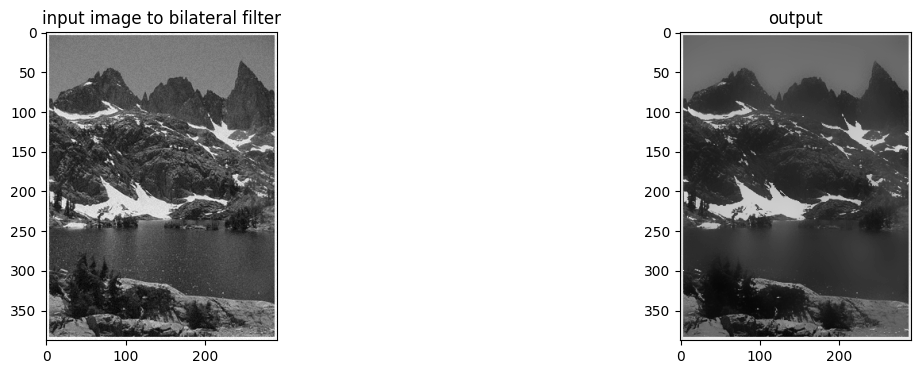

In [20]:
s1 = time.time()
# apply bilatera filter on the noisy image to smoothen it and reduce noise
outImg =  Bilateral (noisy ,sigmas, sigmar, w, tol)
e1 = time.time()

print("time taken for bilateral filtering = " , e1-s1 , "seconds")
print ("MAE" , np.mean ( abs ( outImg - orig ) ) )
plt.figure (figsize=(15,4))
plt.subplot(121) ; plt.imshow(noisy,'gray') ; plt.title("input image to bilateral filter")
plt.subplot(122) ; plt.imshow(outImg,'gray') ; plt.title("output")

# plt.subplot ( 133)
# plt.imshow(blurred,'gray')
# plt.title ( "blurred with just spatial" )
plt.show ( )

Let us see the application of this bilarteral filter on a color image, which is acheived by applying bilateral filter on each of the color channels seperately and merging them back together.

N =  17.0,  2^N =  131072.0
N =  17.0,  2^N =  131072.0
N =  17.0,  2^N =  131072.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


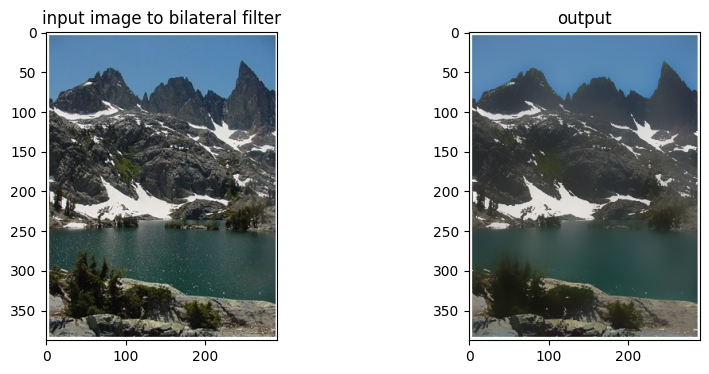

In [30]:
# Read image 

cimg = cv2.cvtColor ( cv2.imread('./lakeside.jpg') , cv2.COLOR_BGR2RGB )

# split the image into its channels
r,g,b = cv2.split(cimg)

# split channel wise and call the  bilateral filter on each channel 
b_bi = Bilateral (b ,sigmas, sigmar, w, tol).astype ( int )
g_bi = Bilateral (g ,sigmas, sigmar, w, tol).astype ( int )
r_bi = Bilateral (r ,sigmas, sigmar, w, tol).astype ( int )


# merge the channels back together
cimg_bi = cv2.merge((r_bi,g_bi,b_bi)).astype ( int )

plt.figure (figsize=(10,4))
plt.subplot(121) ; plt.imshow(cimg,'gray') ; plt.title("input image to bilateral filter")
plt.subplot(122) ; plt.imshow(cimg_bi,'gray') ; plt.title("output") ;plt.show ( )

Let's see the time-performance of the bilateral filter with changing kernel size

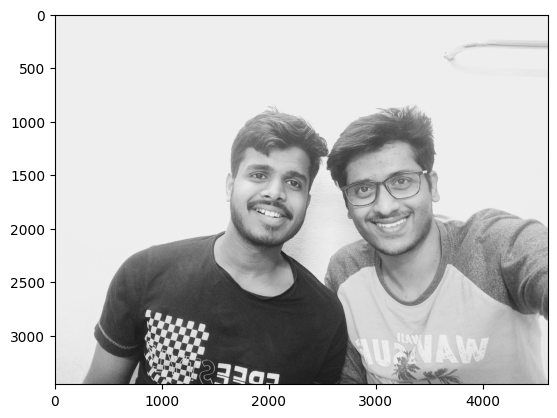

In [33]:
w = [5 , 7 , 9, 21, 35, 67, 85 , 121 ]

img_s = cv2.imread('./selfie.jpg' , 0) 
plt.imshow ( img_s , cmap = "gray" )
plt.show ( ) 
